# CS 267A - Final Project
# Modeling Network Data with Probabilistic Graphical Models and Probabilistic Programming

# Part 1: Inference on Graphs
## Peter Racioppo

In [184]:
# Imports

import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams

import random
import math
from scipy.linalg import eig
import networkx as nx

## Basic Matrix Stuff

In [185]:
# Build random matrix
def f_Random_Matrix(n,k):
    u = np.random.choice([0,1],size=n**2,p=[1-k/n,k/n])
    G = np.reshape(u,[n,n])
    return G

In [186]:
# Convert an adjacency matrix to a stochastic matrix:
# Add a small, nonzero probability of transitioning
# to a vertex that is not connected by an edge
def f_Stochastic_Mat(G,p=0.90):
    n = np.shape(G)[0]
    r = G.sum(axis=1)
    M = np.zeros((n,n))
    for i in np.arange(n):
        for j in np.arange(n):
            if r[i] != 0:
                M[i,j] = p*G[i,j]/max(1,r[i]) + (1-p)/n
            else:
                M[i,j] = 1/n
        
    # Do rows sum to 1?
    if sum(M.sum(axis=1)-1) > 1e-10:
        print("Error.")
        
    return M

In [187]:
# Convert an adjacency matrix to a stochastic matrix:
def f_Stochastic_Mat2(G):
    n = np.shape(G)[0]
    r = G.sum(axis=1)
    M = np.zeros((n,n))
    for i in np.arange(n):
        for j in np.arange(n):
            if r[i] != 0:
                M[i,j] = G[i,j]/max(1,r[i])
        
    # Do rows sum to 1?
    if sum(M.sum(axis=1)-1) > 1e-10:
        print("Error.")
        
    return M

In [188]:
# This function plots a network with vertex colorings
def f_Plot_Graph(G,state,node_size=100):
  color_map = []
  for vertex in state:
      if vertex == 1:
          color_map.append('blue')
      else: 
          color_map.append('green')      
  fig = plt.figure()
  nx.draw(nx.from_numpy_matrix(G), node_size = node_size, node_color=color_map, with_labels=False)
  plt.show()

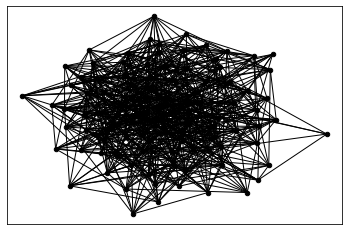

In [214]:
# Generate random matrix and plot:

n = 100 # Number of vertices
k = 8 # Average number of (directed) edges per vertex
G = f_Random_Matrix(n,k) # Make random matrix
Gs = ((G+G.T)>0)*1 # Make undirected version
Ms = f_Stochastic_Mat(Gs) # Make stochastic matrix
# M.sum(axis=1)

nx.draw_networkx(nx.from_numpy_matrix(Gs),with_labels=False,node_size=20,node_color='k')
plt.show()

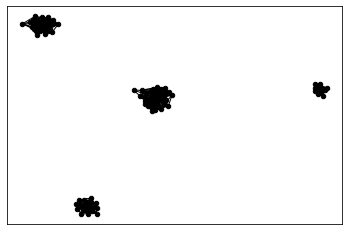

In [215]:
# Generate random matrix with four clusters

n = 100 # Number of vertices
k = 7 # Average number of (directed) edges per vertex
# Cluster parameters:
n1 = 20
n2 = 30
n3 = 40
n4 = 10

Ga = np.eye(n,n)
# Define clusters:
Ga[0:n1,0:n1] = f_Random_Matrix(n1,k)
Ga[n1:n1+n2,n1:n1+n2] = f_Random_Matrix(n2,k)
Ga[n1+n2:n1+n2+n3,n1+n2:n1+n2+n3] = f_Random_Matrix(n3,k)
Ga[n1+n2+n3:n1+n2+n3+n4,n1+n2+n3:n1+n2+n3+n4] = f_Random_Matrix(n4,k)
Gas = ((Ga+Ga.T)>0)*1 # Make undirected version

nx.draw_networkx(nx.from_numpy_matrix(Gas),with_labels=False,node_size=20,node_color='k')
plt.show()

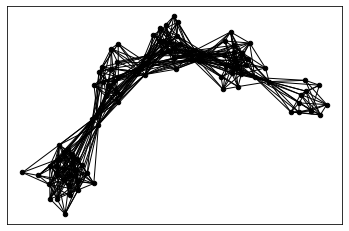

In [216]:
# Generate random matrix with five overlapping clusters:
n = 100 # Number of vertices
k = 7 # Average number of (directed) edges per vertex
Gb = np.eye(n,n)
# Define clusters:
Gb[0:30,0:30] = f_Random_Matrix(30,k)
Gb[27:50,27:50] = f_Random_Matrix(23,k)
Gb[45:70,45:70] = f_Random_Matrix(25,k)
Gb[65:90,65:90] = f_Random_Matrix(25,k)
Gb[88:100,88:100] = f_Random_Matrix(12,k)
Gbs = ((Gb+Gb.T)>0)*1 # Make undirected version

nx.draw_networkx(nx.from_numpy_matrix(Gbs),with_labels=False,node_size=20,node_color='k')
plt.show()

## Page Rank

In [ ]:
# This function computes the stationary distribution
# of a matrix K, using one of three methods.
def f_Stationary(K,method=3):
  if method == 1:
    # METHOD 1: Using left and right eigenvectors:
    # Get eigenvals and left and right eigenvecs:
    w, vl, vr = eig(K, left=True)
    # Get indices of eigenvals by largest modulus:
    idx = np.abs(w).argsort()[::-1]
    # Sort eigenvals/vecs by largest modulus:
    w = w[idx]
    vl = vl[:,idx]
    vr = vr[:,idx]
    u1 = vl[:,0] # First left eigenvec
    v1 = vr[:,0] # First right eigenvec
    # K^n is the outer product of the left and right eigenvectors
    Kn = np.real(np.multiply.outer(v1, u1))
    pi = Kn[0,:] # Stationary distribution
    pi = pi/np.sum(pi)
  
  if method == 2:
    # METHOD 2: Brute force (compute K^n)
    nu = np.ones(np.shape(K)[0])/np.shape(K)[0]
    Kn2 = np.linalg.matrix_power(K,1000)
    pi = np.matmul(nu,Kn2) # Stationary distribution
    pi = pi/np.sum(pi)

  if method == 3:
    # METHOD 3: solve a system of equations
    import warnings
    warnings.filterwarnings("ignore")
    n = K.shape[0]
    A = (np.eye(n) - K).T
    a = np.vstack((A, np.ones(n)))
    b = np.matrix([0]*n + [1]).T
    pi = np.squeeze(np.asarray(np.linalg.lstsq(a,b)[0].T))
  
  return pi

In [ ]:
# The stationary distribution of the Markov chain over G is: Π = deg(v)/2m
def f_Stationary_closed_form(G):
  edges_out = np.sum(G,axis=1) # For each row, sum all the columns
  edges_in = np.sum(G,axis=0) # For each column, sum all the rows
  deg = edges_out + edges_in

  m = np.sum(G) + sum(np.diag(G))
  pi = deg/(2*m)
  return deg, m, pi

2.5218542532012833e-16
2.736526283353413e-16


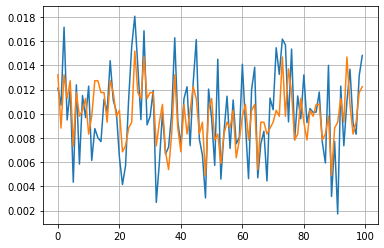

In [ ]:
# All three numerical methods give the same result for the 
# stationary distribution, but the closed form is different.
M2 = f_Stochastic_Mat2(G)
stat1 = f_Stationary(M2,method=1)
stat2 = f_Stationary(M2,method=2)
stat3 = f_Stationary(M2,method=3)
_, _, stat4 = f_Stationary_closed_form(G)

print(sum(stat1-stat2))
print(sum(stat1-stat3))

plt.plot(stat1)
plt.plot(stat4)
plt.grid()
plt.show()

In [ ]:
# Computes page rank of vertices in adjacency matrix G
def f_Page_Rank(G):
    M = f_Stochastic_Mat(G)
    v = f_Stationary(M)
    page_rank = np.abs(v).argsort()[::-1]
    v_sort = v[page_rank]
    return page_rank, v, v_sort

In [ ]:
# This is another (equivalent) version of the page rank algorithm.

def f_Page_Rank2(G):
  M = f_Stochastic_Mat(G)
  # Initialize vectors
  v_i = np.zeros(n)
  v_i[0] = 1
  v_f = v_i
  v = np.zeros(n)

  it = 0
  tol = 0.00001
  while max(abs(v_f - v)) > tol:
      v = v_f
      v_f = np.matmul(v,M)
      it += 1
  page_rank = np.abs(v).argsort()[::-1]
  v_sort = v_f[page_rank]
  return page_rank, v_f, v_sort

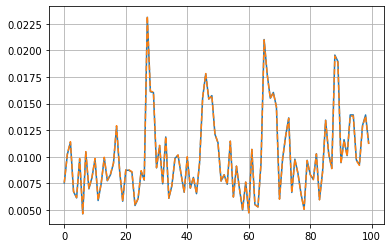

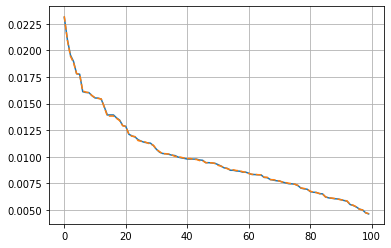

In [ ]:
# Run page rank on the random graph with five clusters:

page_rank, v, v_sort = f_Page_Rank(Gb)
page_rank2, v2, v_sort2 = f_Page_Rank2(Gb)

# Plot page ranks of the vertices:
fig = plt.figure()
ax = fig.add_subplot()
# ax.set_yscale('log')
plt.plot(v)
plt.plot(v2,'--')
plt.grid()

# Plot sorted version:
fig = plt.figure()
ax = fig.add_subplot()
# ax.set_yscale('log')
plt.plot(v_sort)
plt.plot(v_sort2,'--')
plt.grid()

# The results are identical.

### Compute page rank again by doing a random walk on the graph

In [ ]:
# Compute random walk through adjacency matrix G:
def f_Random_Walk(G,n,it=10000):
    n = np.shape(G)[0]
    M = f_Stochastic_Mat(G)
    vertices = np.arange(n) # List of vertices
    v = []
    for i in np.arange(it):
        v_i = np.random.choice(vertices) # Start at a random vertex
        v_n = np.random.choice(vertices,p=M[v_i,:]) # Randomly move to a new vertex
        v.append(v_n)
    
    v_hist, bin_edges = np.histogram(v,bins=n,density=True)
    page_rank = np.abs(v_hist).argsort()[::-1]
    v_sort = v_hist[page_rank]

    return page_rank, v_hist, v_sort

In [ ]:
# The expected number of steps required to visit every vertex in the 
# graph is bounded above by 4nm (where n is the number of vertices and m 
# is the number of edges)

def f_Expected_Num_Steps(G):
  n = np.shape(G)[0]
  m = np.sum(G) + sum(np.diag(G))
  expected_num_steps = 4*n*m
  return expected_num_steps

In [ ]:
# Comparing the PageRank algorithm with a random walk:

page_rank, v, v_sort = f_Page_Rank(Gb)

it = f_Expected_Num_Steps(Gb)
print("Number of iterations =", int(it))
page_rank_Markov, v_Markov, v_sort_Markov = f_Random_Walk(Gb,n,it=it)

Number of iterations = 461200


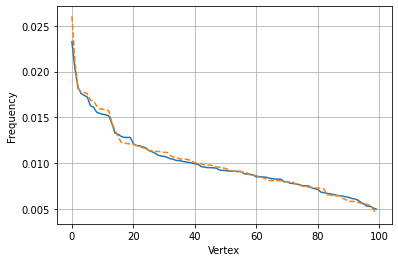

In [ ]:
plt.plot(v_sort)
plt.plot(v_sort_Markov,'--')
plt.grid()
plt.xlabel('Vertex')
plt.ylabel('Frequency')
plt.show()

## Convergence of Markov Chains
### In this section, we write functions to compute the bottleneck and conductance of an arbitrary graph, and verify Poincare's and Cheeger's inequalities. These inequalities bound lambda_slem, the second-largest eigenvalue modulus, which in turn bounds MCMC convergence by the Diaconis-Hanlon bound.

In [ ]:
# Example matrix
K = np.array([[0.1, 0.8, 0.1, 0.0, 0.0],
              [0.3, 0.0, 0.7, 0.0, 0.0],
              [0.1, 0.6, 0.0, 0.3, 0.0],
              [0.0, 0.0, 0.1, 0.6, 0.3],
              [0.0, 0.0, 0.2, 0.4, 0.4]])

### We calculate the invariant probability π(x) for the five states and compute the value of λ_slem, the second largest eigenvalue modulus.

In [ ]:
pi = f_Stationary(K)
print("The invariant probability of K is:")
print(pi)

# w: The eigenvalues, each repeated according to its multiplicity.
w, vl, vr = eig(K, left=True)
# Get indices of eigenvals by largest modulus:
idx = np.abs(w).argsort()[::-1]
# Sort eigenvals/vecs by largest modulus:
w = w[idx]

print("The eigenvalues of K are:")
print(w)

# λ_slem
lambda_slem = np.abs(w[1])
print("λ_slem = ", lambda_slem)

The invariant probability of K is:
[0.09195402 0.20361248 0.21674877 0.32512315 0.16256158]
The eigenvalues of K are:
[ 1.        +0.j  0.77309315+0.j -0.74733351+0.j  0.11149688+0.j
 -0.03725652+0.j]
λ_slem =  0.7730931498158939


### We now compute the edge e = (x,y) which is the bottleneck of G. We then verify the Poincare inequality:
### λ_slem ≤ 1− 1/κ.

### Computing the bottleneck is an NP-hard problem.

In [ ]:
G = np.double((K>0)) # Adjacency matrix of K:
num_edges = int(np.sum(G)) # Number of edges

In [ ]:
# Find the number of edges in an adjacency matrix and store them in edge_vec.
def f_edges(G):
    n = np.shape(G)[0]
    edge_vec = []
    for i in np.arange(n):
        for j in np.arange(n):
            if G[i,j]==1:
                edge_vec.append([i,j])
    return edge_vec

In [ ]:
edge_vec_G = f_edges(G)

print(edge_vec_G)
print("Number of edges = ", np.shape(edge_vec_G)[0])

[[0, 0], [0, 1], [0, 2], [1, 0], [1, 2], [2, 0], [2, 1], [2, 3], [3, 2], [3, 3], [3, 4], [4, 2], [4, 3], [4, 4]]
Number of edges =  14


In [ ]:
# Build G0 matrix:
# (Each vertex in G0 is an edge in G. Vertices in G0 have an edge between them
# if and only if the corresponding edges in G meet at some vertex.)
G0 = np.zeros((num_edges,num_edges))
for i in np.arange(num_edges):
    for j in np.arange(num_edges):
       if edge_vec_G[i][1] == edge_vec_G[j][0]:
            G0[i,j] = 1
G0

array([[1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
       [0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.]])

In [ ]:
def f_Plot_Directed_Graph(G0):
    import networkx as nx
    n = np.shape(G0)[0]
    options = {'node_color': 'gray'}
    G = nx.DiGraph()
    for i in range(n):
        for j in range(n):
            if G0[i][j] == 1:
                G.add_edge(i,j)
    import matplotlib.pyplot as plt
    nx.draw(G, with_labels=True, font_weight='bold', **options)
    plt.show()

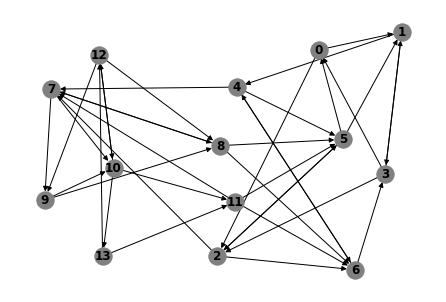

In [ ]:
f_Plot_Directed_Graph(G0)

In [ ]:
# Compute a list of the edges in G0:
edge_vec_G0 = f_edges(G0)

print(edge_vec_G0)
print("Number of edges = ", np.shape(edge_vec_G0)[0])

[[0, 0], [0, 1], [0, 2], [1, 3], [1, 4], [2, 5], [2, 6], [2, 7], [3, 0], [3, 1], [3, 2], [4, 5], [4, 6], [4, 7], [5, 0], [5, 1], [5, 2], [6, 3], [6, 4], [7, 8], [7, 9], [7, 10], [8, 5], [8, 6], [8, 7], [9, 8], [9, 9], [9, 10], [10, 11], [10, 12], [10, 13], [11, 5], [11, 6], [11, 7], [12, 8], [12, 9], [12, 10], [13, 11], [13, 12], [13, 13]]
Number of edges =  40


In [ ]:
# (Finding the set of all simple paths is an NP-hard problem.)

# Build G0 as a networkx object:
import networkx as nx
G0_nx = nx.DiGraph() # Build a directed graph
G0_nx.add_nodes_from(np.arange(num_edges)) # Add 14 nodes
G0_nx.add_edges_from(edge_vec_G0) # Add the edges in G0

# Check the nodes and edges:
# print(G0_nx.number_of_nodes())
# print(G0_nx.number_of_edges())
# G0_nx.edges()

In [ ]:
# Find the simple paths in G0 from source to target:
def f_simple_paths_ij(G0,source,target):
    i = 0
    simple_paths = []
    for path in nx.all_simple_paths(G0, source=source, target=target):
        simple_paths.append(path)
        i += 1
    return simple_paths

In [ ]:
# Find all simple paths in G0
simple_paths_list = []
# Loop through all sources and targets.
for source in np.arange(num_edges):
    for target in np.arange(num_edges):
        if source != target:
            simple_paths_list.append(f_simple_paths_ij(G0_nx,source,target))

simple_paths = np.array([i for sublist in simple_paths_list for i in sublist]) # Flatten the list

# We want the unique simple paths.
# (In fact, we don't need this line. They're unique by construction.)
# simple_paths = np.unique(simple_paths)

L = np.shape(simple_paths)[0] # The number of simple paths in G0
print("There are", L, "simple paths.")

# Convert to array of arrays:
for i in np.arange(L):
    simple_paths[i] = np.array(simple_paths[i])
print(simple_paths)

There are 18050 simple paths.
[array([0, 1]) array([0, 2, 5, 1]) array([0, 2, 6, 3, 1]) ...
 array([13, 11,  7,  9, 10, 12]) array([13, 11,  7, 10, 12])
 array([13, 12])]


In [ ]:
# Given an edge and the list of all simple_paths,
# this function finds all simple paths which do
# not contain that edge:
def f_Gamma_e(edge,simple_paths):
    L = np.shape(simple_paths)[0]
    Paths = []
    for i in np.arange(L):
        if edge not in simple_paths[i]:
            Paths.append(simple_paths[i])
    return Paths

In [ ]:
# This function computes the effective length gamma of a weighted path Gamma.
# Gamma is a weighted path that contains each edge at most one time.
def f_gamma(Gamma,pi,K):
    gamma = 0
    for e in Gamma:
        s = int(e[0])
        t = int(e[1])
        gamma += 1/(pi[s]*K[s,t])
    return gamma

edge_vec_G
print(edge_vec_G)
f_gamma(edge_vec_G,pi,K)

[[0, 0], [0, 1], [0, 2], [1, 0], [1, 2], [2, 0], [2, 1], [2, 3], [3, 2], [3, 3], [3, 4], [4, 2], [4, 3], [4, 4]]


431.3369073802546

In [ ]:
# Convert indices of a path to the actual path in G.
def f_dict(Gamma_xy_idx):
    L_gxy = np.shape(Gamma_xy_idx)[0]
    Gamma_xy = np.zeros((L_gxy,2))
    for i in np.arange(L_gxy):
        Gamma_xy[i,:] = edge_vec_G[Gamma_xy_idx[i]]
    return Gamma_xy

In [ ]:
# Calculate the sum over all valid paths:

k = np.zeros(num_edges)

for edge in np.arange(num_edges):
    Paths = f_Gamma_e(edge,simple_paths)

    k_e = 0
    for Gamma_xy_idx in Paths:
        Gamma_xy = f_dict(Gamma_xy_idx)
        x = int(Gamma_xy[0][0])
        y = int(np.flip(Gamma_xy)[0][0])
        k_e += f_gamma(Gamma_xy,pi,K)*pi[x]*pi[y]

    k[edge] = k_e

k

array([ 67182.98188467,  51734.29390889,  30476.08450603,  49901.12525629,
        62904.73883435,  22199.76590234,  39093.06690182,  22718.67252753,
        58076.01479932,  81108.52210897,  30763.53661763,  86267.47957969,
        96507.57994962, 105178.47727519])

The bottleneck is [4, 4]
kappa = 105178.47727518746
λ_slem ≤ 0.999990492351421


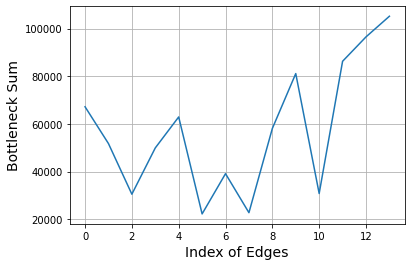

In [ ]:
plt.plot(k)
plt.xlabel('Index of Edges', fontsize=14)
plt.ylabel('Bottleneck Sum', fontsize=14)
plt.grid()

e_star = np.argmax(k)
kappa = np.max(k)
bottleneck = edge_vec_G[e_star]

print("The bottleneck is", bottleneck)
print("kappa =", kappa)
print("λ_slem ≤", 1 - 1/kappa)

### We now calculate the conductance h of the graph G and verify Cheeger’s inequalities:
### 1 − 2h ≤ λ_slem ≤ 1 − h^2/2.
### Computing the conductance of a graph is an NP-hard problem.

In [ ]:
# Computing S and Sc:

# There are 5 states.
states = np.array([0, 1, 2, 3, 4])
n = 2**np.size(states) # The number of subsets
m = int(n/2) # Half the number of subsets

from itertools import chain, combinations
# Computes the powerset of x:
def powerset(x):
    # The powerset as a list:
    ps = list(chain.from_iterable(combinations(x,n) for n in np.arange(np.size(x)+1)))
    return np.array([np.array(xi) for xi in ps]) # Retun as a numpy array of numpy arrays

# We divide the state space Ω into two subspaces such that Ω = S ∪ Sc 
S = powerset(states) # Return the powerset
S = S[1:n] # We can remove the empty set from S.
# Sc = np.flip(S) # Flipped to match the missing parts of S.
n2 = np.shape(S)[0]
print(S)
# print(Sc)

[array([0]) array([1]) array([2]) array([3]) array([4]) array([0, 1])
 array([0, 2]) array([0, 3]) array([0, 4]) array([1, 2]) array([1, 3])
 array([1, 4]) array([2, 3]) array([2, 4]) array([3, 4]) array([0, 1, 2])
 array([0, 1, 3]) array([0, 1, 4]) array([0, 2, 3]) array([0, 2, 4])
 array([0, 3, 4]) array([1, 2, 3]) array([1, 2, 4]) array([1, 3, 4])
 array([2, 3, 4]) array([0, 1, 2, 3]) array([0, 1, 2, 4])
 array([0, 1, 3, 4]) array([0, 2, 3, 4]) array([1, 2, 3, 4])
 array([0, 1, 2, 3, 4])]


In [ ]:
# Computing pi_S:

# Computing the vectors of pi values for each S:
pi_S_vec = []
for i in np.arange(n2):
    idx = S[i]
    pi_S_vec.append(pi[idx])

# Computing the sum of pi_S_vec for each S:
pi_S = np.zeros(n)
for i in np.arange(n2):
    pi_S[i+1] = np.sum(pi_S_vec[i])

pi_S = pi_S[1:n-1] # Remove the empty and complete sets

# Compute the indices where pi(S) <= 1/2
indices = np.where(pi_S <= 1/2)[0]
# Compute the values of pi(S) at these indices:
# pi_S_p = pi_S[indices]
print(indices)
# print(pi_S_p)

[ 0  1  2  3  4  5  6  7  8  9 11 13 14 17 19]


In [ ]:
# This function computes Q(s,sc):
def f_Q(s,sc,K):
    Q = 0
    for x in s:
        for y in sc:
            Q += pi[x]*K[x,y]
    return Q

Conductance = 0.13333333333333333


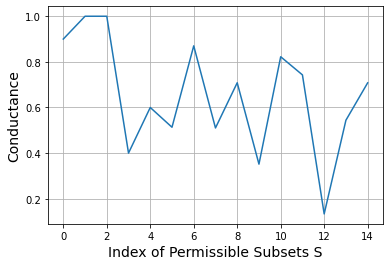

In [ ]:
S2 = S[0:n-2] # Remove the complete set from S.
Sc2 = np.flip(S2) # Flipped to match the missing parts of S.

# Compute the conductance:
h_vec = np.zeros(np.shape(indices))
j = 0
for i in indices:
    h_vec[j] = f_Q(S2[i],Sc2[i],K)/pi_S[i]
    j += 1

# Plot of the conductance:
plt.plot(h_vec)
plt.xlabel('Index of Permissible Subsets S', fontsize=14)
plt.ylabel('Conductance', fontsize=14)
plt.grid()

h = min(h_vec)
print("Conductance =", h)

In [ ]:
lower_bound = 1-2*h
upper_bound = 1 - (h**2)/2

print("Lower bound = ", lower_bound)
print("Upper bound = ", upper_bound)
print("λ_slem = ", lambda_slem)
print("Cheeger's inequalities are satisfied.")

Lower bound =  0.7333333333333334
Upper bound =  0.9911111111111112
λ_slem =  0.7730931498158939
Cheeger's inequalities are satisfied.


### Now since we know π, we can design the “dream” matrix K* that converges in one step. Then λ_slem = 0 for K*.
### We calculate the conductance h for K* and again verify Cheeger’s inequalities.

In [ ]:
# Construct K* (K* = [pi pi ... pi].T):
K_star = np.zeros((5,5))
for i in np.arange(np.shape(K)[1]):
    K_star[i,:] = pi
K_star

array([[0.09195402, 0.20361248, 0.21674877, 0.32512315, 0.16256158],
       [0.09195402, 0.20361248, 0.21674877, 0.32512315, 0.16256158],
       [0.09195402, 0.20361248, 0.21674877, 0.32512315, 0.16256158],
       [0.09195402, 0.20361248, 0.21674877, 0.32512315, 0.16256158],
       [0.09195402, 0.20361248, 0.21674877, 0.32512315, 0.16256158]])

Conductance = 0.5123152709359602


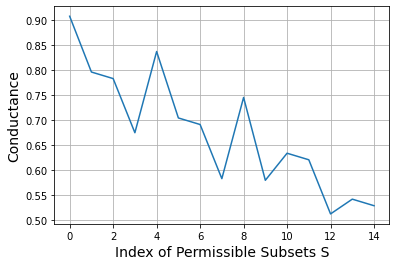

In [ ]:
S2 = S[0:n-2] # Remove the complete set from S.
Sc2 = np.flip(S2) # Flipped to match the missing parts of S.

# Compute the conductance:
h_vec = np.zeros(np.shape(indices))
j = 0
for i in indices:
    h_vec[j] = f_Q(S2[i],Sc2[i],K_star)/pi_S[i]
    j += 1

# Plot of the conductance:
plt.plot(h_vec)
plt.xlabel('Index of Permissible Subsets S', fontsize=14)
plt.ylabel('Conductance', fontsize=14)
plt.grid()

h = min(h_vec)
print("Conductance =", h)

In [ ]:
lower_bound = 1-2*h
upper_bound = 1 - (h**2)/2

print("Lower bound = ", lower_bound)
print("Upper bound = ", upper_bound)
print("λ_slem = ", 0)
print("Cheeger's inequalities are again satisfied.")

Lower bound =  -0.024630541871920375
Upper bound =  0.8687665315829068
λ_slem =  0
Cheeger's inequalities are again satisfied.


## Load Facebook Data:

In [ ]:
# Load Facebook Data:
# https://snap.stanford.edu/data/egonets-Facebook.html
# https://www.datacamp.com/community/tutorials/social-network-analysis-python

G_fb = nx.read_edgelist("facebook_combined.txt", create_using = nx.Graph(), nodetype=int)
G_np = nx.to_numpy_matrix(G_fb)
print(nx.info(G_fb))

Name: 
Type: Graph
Number of nodes: 4039
Number of edges: 88234
Average degree:  43.6910


In [ ]:
# Check that the graph is undirected
# (check if the adjacency matrix is symmetric):
if np.sum(G_np.T - G_np) == 0:
    print("The network is undirected.")

The network is undirected.


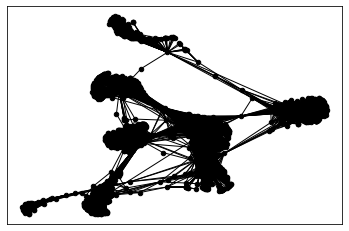

In [ ]:
# Plot the Facebook data:

nx.draw_networkx(G_fb,with_labels=False,node_size=20,node_color='k')
plt.show()

# There seem to be about 8 large clusters.

(-1.0992905259132386,
 1.0851023554801942,
 -0.8909261018037796,
 1.0500078588724135)

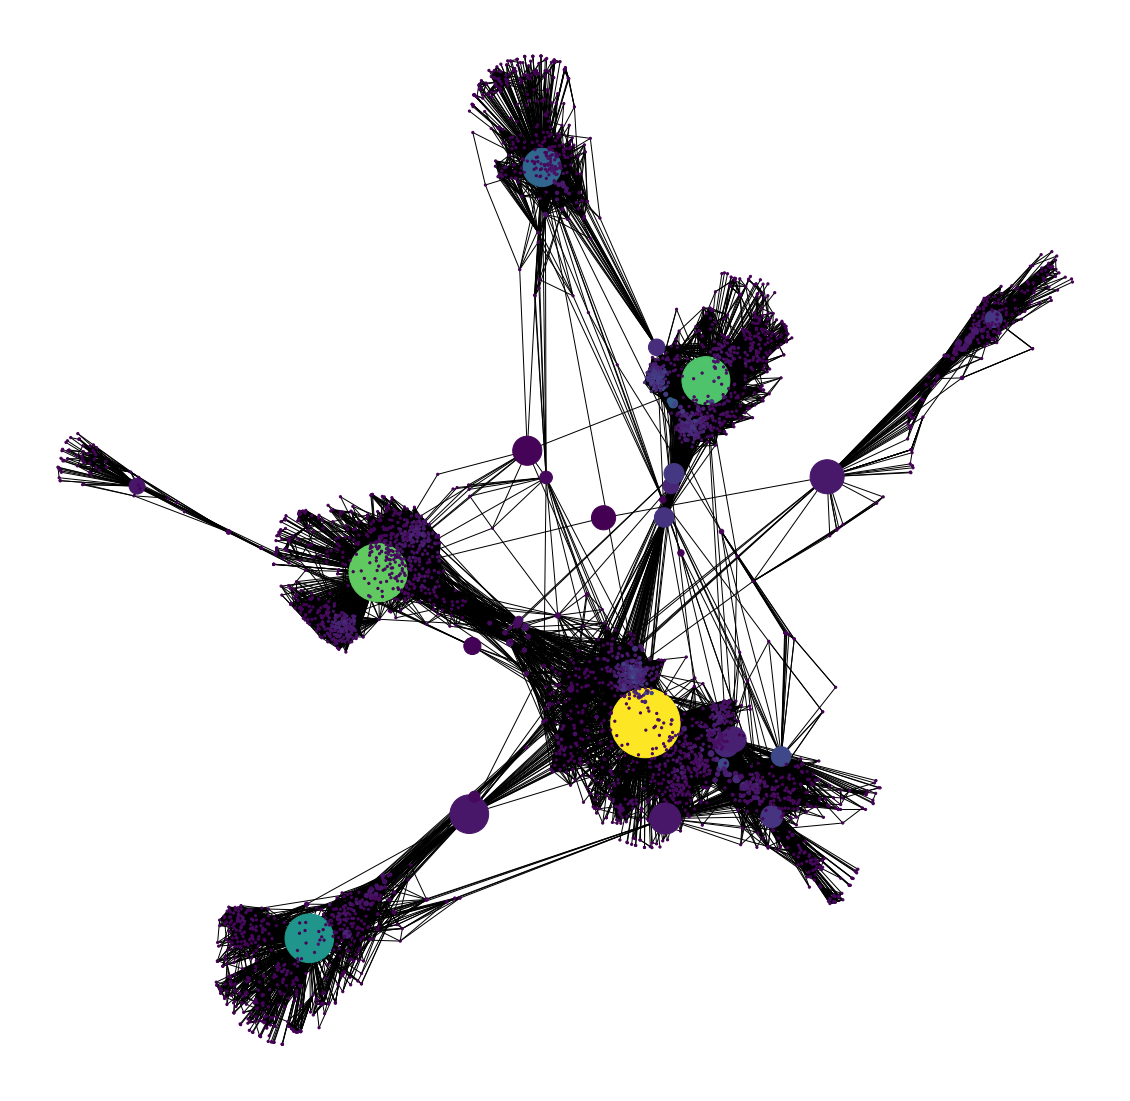

In [ ]:
# Plot the Facebook data (more detail):

betCent = nx.betweenness_centrality(G_fb, normalized=True, endpoints=True) # Betweenness centrality
node_color = [20000.0 * G_fb.degree(v) for v in G_fb] # Node color
node_size =  [v * 10000 for v in betCent.values()] # Node size
pos = nx.spring_layout(G_fb) # Layout
plt.figure(figsize=(20,20))
nx.draw_networkx(G_fb, pos=pos, with_labels=False,
                 node_color=node_color,
                 node_size=node_size )
plt.axis('off')

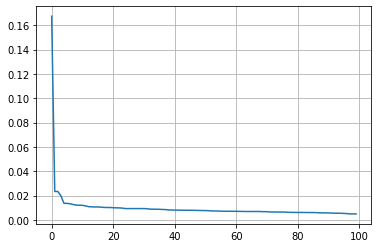

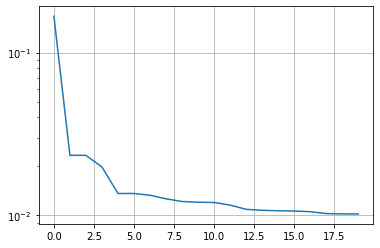

In [ ]:
# Run page rank on the Facebook data:

page_rank, v, v_sort = f_Page_Rank(G_np)

fig = plt.figure()
ax = fig.add_subplot()
# ax.set_yscale('log')
plt.plot(v_sort)
plt.grid()

fig = plt.figure()
ax = fig.add_subplot()
ax.set_yscale('log')
plt.plot(v_sort[0:20])
plt.grid()

## Markov Clustering (MCL)

In [ ]:
# This function normalizes the columns of a matrix G
def f_Normalize(G):
    n = np.shape(G)[0]
    c = np.ndarray.flatten(np.array(G.sum(axis=0))) # Column sum
    M = np.zeros((n,n))
    for j in np.arange(n):
        M[:,j] = np.ndarray.flatten(G[:,j])/max(1,c[j])
        
    return M

In [ ]:
# Expansion operation in MCL algorithm:
# Here, we compute M^e.
def f_Expansion(M,e):
    return np.linalg.matrix_power(M,e)

In [ ]:
# # Inflation operation in MCL algorithm:
# # Here, we take each element in M to the rth power
# # and then renormalize the columns. The effect of
# # this operation is to weaken the weak connections
# # and strengthen the strong ones, which encourages
# # the breaking of the matrix into clusters.
# def f_Inflation(M,r):
#     R = np.empty_like(M)
#     R[:] = M
#     n = np.shape(R)[0]
#     for j in np.arange(n):
#         Sum = 0
#         for i in np.arange(n):
#             R[i,j] = M[i,j]**r
#             Sum += R[i,j]
#         R[:,j] /= Sum
    
#     return R

In [ ]:
# Inflation operation in MCL algorithm:
# Here, we take each element in M to the rth power
# and then renormalize the columns. The effect of
# this operation is to weaken the weak connections
# and strengthen the strong ones, which encourages
# the breaking of the matrix into clusters.
def f_Inflation(M,r):
    R = np.empty_like(M)
    R[:] = M
    n = np.shape(R)[0]
    for j in np.arange(n):
        R[:,j] = M[:,j]**r # Take element-wise power
        R[:,j] /= np.sum(R[:,j]) # Renormalize columns
    
    return R

In [ ]:
# Markov Clustering Algorithm:
# Description at: https://micans.org/mcl/
def f_MCL(G,it=10,e=3,r=4):
    for i in np.arange(n):
        # We first add self-loops, to improve convergence.
        G[i,i] = 1

    R = f_Normalize(G) # Normalize the columns

    # Alternate the expansion and inflation steps
    for i in np.arange(it):
        E = f_Expansion(R,e)
        R = f_Inflation(E,r)
        
    return R

In [ ]:
# Converts a stochastic matrix to the corresponding adjacency matrix
def f_Stochastic_to_Adjacency(S,threshold=1e-10):
    # Remove elements smaller than some threshold
    n = np.shape(S)[0]
    adj = np.zeros((n,n))
    for i in np.arange(n):
        for j in np.arange(n):
            if S[i,j] > threshold:
                adj[i,j] = 1
    return S

In [ ]:
# Given an adjacency matrix of disjoint graphs, and a labeling of the vertices,
# returns the indices of each connected component, and the most common label
# in each disjoint graph.
def f_Cluster_Labels(adj,state):
  g = nx.Graph(adj)
  components = [g.subgraph(c).copy() for c in nx.connected_components(g)]
  cluster_label = np.zeros(np.shape(components)[0])
  i = 0
  for cc in components:
      cluster_label[i] = np.int(np.sum(state[cc.nodes]) >= 0)
      i += 1

  cluster_label = cluster_label*2 - 1
  return components, cluster_label

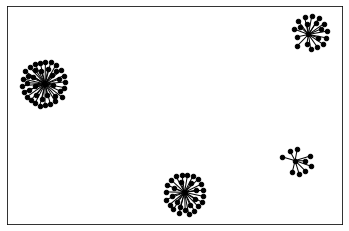

In [ ]:
# Test MCL on our random matrix with four non-overlapping clusters:

R = f_MCL(Gas,e=3,r=4)
adj = f_Stochastic_to_Adjacency(R)
nx.draw_networkx(nx.from_numpy_matrix(adj),with_labels=False,node_size=20,node_color='k',edge_color="black")

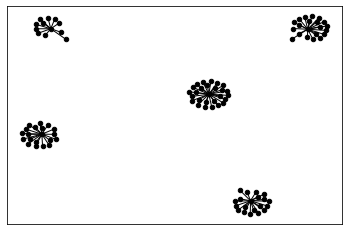

In [ ]:
# Test MCL on our random matrix with five overlapping clusters:

R = f_MCL(Gb,e=3,r=4)
adj = f_Stochastic_to_Adjacency(R)
nx.draw_networkx(nx.from_numpy_matrix(adj),with_labels=False,node_size=20,node_color='k',edge_color="black")

[[1. 1. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


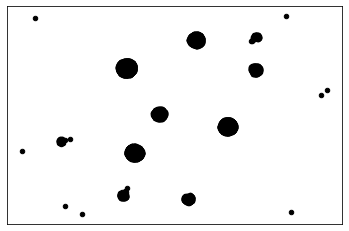

In [ ]:
# Apply MCL to the Facebook Data:

R = f_MCL(G_np,it=15,e=2,r=3)
adj = f_Stochastic_to_Adjacency(R)
# print(adj)
nx.draw_networkx(nx.from_numpy_matrix(adj),with_labels=False,node_size=20,node_color='k',edge_color="black")

## Simulating an Ising model:

In [217]:
# Computes adjacency matrix for an n x n lattice
# with periodic boundary conditions:
def f_2D_Grid_Adjacency(n):
    E = np.zeros((n**2,n**2))
    v = np.arange(n**2)

    for i in v:
        # If we're not at the last element in a row,
        # create an edge to the vertex on our right:
        if np.mod(i+1,n) != 0:
            E[i,i+1] = 1
        # If we're at the last element in a row, create
        # an edge to the first element in the row:
        else:
            E[i,i+1-n] = 1
        # If we're not at the first element in a row,
        # create an edge to the vertex on our left:
        if np.mod(i,n) != 0:
            E[i,i-1] = 1
        # If we're at the first element in a row, create
        # an edge to the last element in the row:
        else:
            E[i,i-1+n] = 1
        # If we're not at the last element in a column, create
        # an edge to the next vertex down:
        if i+n in v:
            E[i,i+n] = 1
        # If we're at the last element in a column, create
        # an edge to the first vertex in the column:
        else:
            E[i,i+n-n**2] = 1
        # If we're not at the first element in a column, create
        # an edge to the next vertex up:
        if i-n in v:
            E[i,i-n] = 1
        # If we're at the first element in a column, create
        # an edge to the last vertex in the column:
        else:
            E[i,i-n+n**2] = 1
            
    return E

<function matplotlib.pyplot.show>

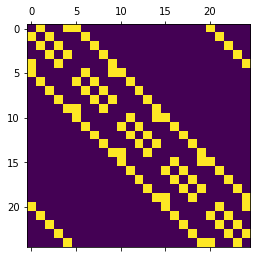

In [ ]:
# Plot the adjacency matrix:
E = f_2D_Grid_Adjacency(n=5)
plt.matshow(E)
plt.show

# print("rank=",np.linalg.matrix_rank(E))
# E_inv = np.linalg.inv(E)
# plt.matshow(E_inv)
# plt.show

In [218]:
# Computes the argument of the Ising Hamiltonian function:
def f_Hamiltonian_arg(E,x):
    # Inputs: adjacency matrix E and state vector x
    Sum = 0
    indices = np.argwhere(E == 1)
    # Loop over all neighboring states.
    # Since we are dealing with an undirected graph, the
    # adjacency matrix is symmetric and we need only look
    # at everything above the main diagonal.
    for i,j in indices:
        if i > j:
            Sum += x[i]*x[j]
    return Sum

In [219]:
# Computes a state transition by Gibbs sampling:
def f_State_Transition(E,beta,state):
    # Create a proposal distribution in which one element has a flipped spin
    proposal = np.empty_like(state)
    proposal[:] = state
    i = np.random.choice(np.shape(state)[0]) # Pick a random state
    proposal[i] = -proposal[i] # Flip the spin of the state
    # Compute the ratio of the Hamiltonians:
    ratio = np.exp(beta*(f_Hamiltonian_arg(E,proposal) - f_Hamiltonian_arg(E,state)))
    alpha = np.minimum(1,ratio) # Acceptance probability
    # Accept the proposal with probability alpha:
    indicator = np.random.choice(a = np.array([1,0]),p=[alpha,1-alpha])
    if indicator == 1:
        state = proposal
    return state

In [220]:
# Simulate the Ising model on a graph with adjacency matrix E
# using Gibbs sampling, with parameter 'beta' and 'it' iterations
def f_Gibbs_Ising(it,beta,E):
    n = np.shape(E)[0]
    # Start from a uniform random distibution:
    state = np.random.choice(a = np.array([1,-1]),size=n)
    for i in np.arange(it):
        state = f_State_Transition(E,beta,state)
    return state

In [221]:
def f_Plot_Lattice(state):
  n = np.shape(state)[0]
  grid_length = int(np.sqrt(n))
  Grid = np.reshape(state,(grid_length,grid_length))
  fig = plt.figure()
  plt.matshow(Grid)
  plt.show

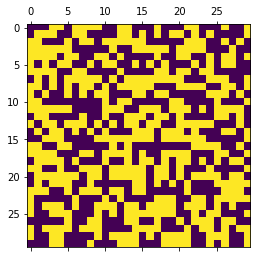

In [ ]:
# Simulate white noise:
grid_length = 30
n = grid_length**2 # Vertices
state1 = np.random.choice(a = np.array([1,-1]),size=n)

f_Plot_Lattice(state1)

<function matplotlib.pyplot.show>

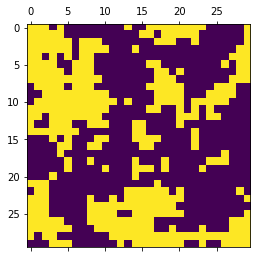

In [ ]:
# Test the Gibbs sampler:
# beta is the "inverse temperature" parameter.

grid_length = 30
it = 10000
beta = 0.1

E = f_2D_Grid_Adjacency(grid_length)
state2 = f_Gibbs_Ising(it,beta,E)

f_Plot_Lattice(state2)

<function matplotlib.pyplot.show>

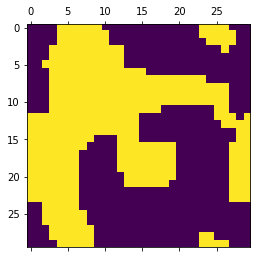

In [ ]:
# Test the Gibbs sampler:

grid_length = 30
it = 10000
beta = 0.5

E = f_2D_Grid_Adjacency(grid_length)
state3 = f_Gibbs_Ising(it,beta,E)

f_Plot_Lattice(state3)

# beta is the "inverse temperature" parameter.
# As beta is increased, the "temperature" decreases,
# and we more commonly see larger blocks in the same state.

<function matplotlib.pyplot.show>

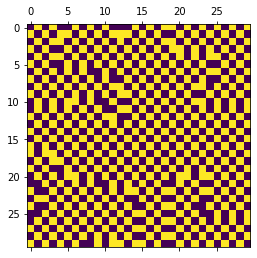

In [ ]:
# Test the Gibbs sampler:
# Using beta with negative sign and sufficiently large modulus,
# we get a checkboard pattern. This corresponds to a high-energy state.

grid_length = 30
it = 10000
beta = -0.5

E = f_2D_Grid_Adjacency(grid_length)
state4 = f_Gibbs_Ising(it,beta,E)

f_Plot_Lattice(state4)

Number of iterations = 1000


<Figure size 432x288 with 0 Axes>

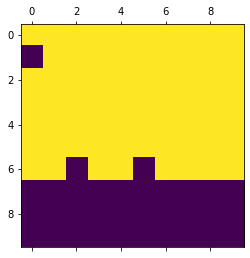

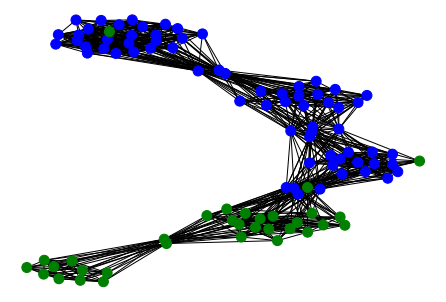

In [ ]:
# Test the Gibbs sampler on the random graph with 5 overlapping clusters:

# Set the number of iterations to be ten times the number of nodes:
it = 10*np.shape(Gbs)[0]
print("Number of iterations =", it)
beta = 0.3

# Sample from Ising model:
state5 = f_Gibbs_Ising(it,beta,Gbs)

f_Plot_Lattice(state5)
f_Plot_Graph(Gbs,state5)

<Figure size 432x288 with 0 Axes>

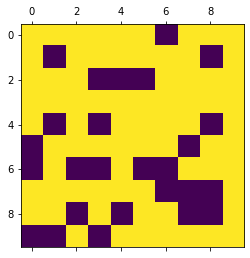

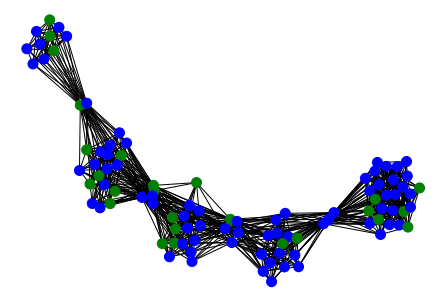

In [ ]:
# Test the Gibbs sampler on the random graph with 5 overlapping clusters:

# Set the number of iterations to be ten times the number of nodes:
it = 10*np.shape(Gbs)[0]
print("Number of iterations =", it)
beta = 0.1

# Sample from Ising model:
state6 = f_Gibbs_Ising(it,beta,Gbs)

f_Plot_Lattice(state6)
f_Plot_Graph(Gbs,state6)

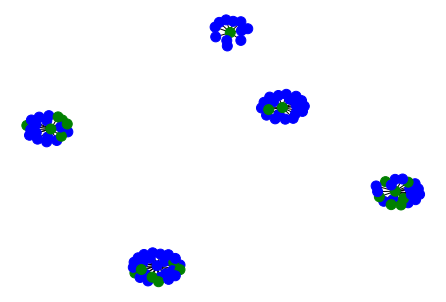

In [ ]:
# Plot the clustered graph:
f_Plot_Graph(adj,state6)

In [ ]:
# Run the Gibbs sampler on the Facebook data:

# Set the number of iterations to be equal to the number of nodes:
it = np.shape(G_np)[0]
beta = 0.1

# Sample from Ising model:
state = f_Gibbs_Ising(it,beta,G_np)

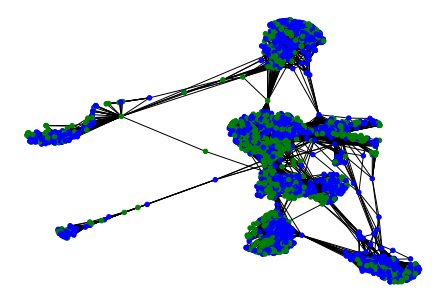

(4039,)

In [ ]:
# Plot the labeled data:
f_Plot_Graph(G_np,state,node_size = 20)

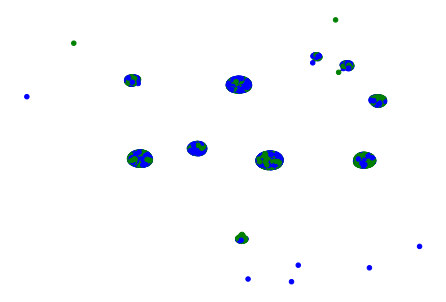

In [ ]:
# Plot the clustered, labeled data:
f_Plot_Graph(adj,state,node_size = 20)

## Inference on Graphs
## Peter Racioppo (1,2,5) and Andrey Storozhenko (3,4)

### If we assume that we know the parameters of the Ising model that generated a distribution of labels, we can predict the labels of an unknown subset of the graph, using the labels of the vertices in their neighborhood.

### (1) Given the labels of all the neighbors of a vertex, predict the label of that vertex.

In [222]:
# Infers the label of a vertex, given the labels of its neighbors
def f_Infer_Vertex_Label_with_Complete_Neighborhood(v,G,state,beta):

  # The Ising model is a Markov Random Field (MRF).
  # A Markov blanket condition holds:
  # p(v_s | v_{−s}) ∝ exp(β ∑_t v_t*v_s).
  v_in = np.where(G[:,v]==1) # Neighborhood of v
  pi1 = np.exp(np.sum(beta*state[v_in])) # Hamiltonian if state[v] = 1
  pim1 = np.exp(np.sum(-beta*state[v_in])) # Hamiltonian if state[v] = -1
  Z = pi1 + pim1 # Partition function

  p1 = pi1/Z # Pr(state[v]) = 1
  # pm1 = pim1/Z # Pr(state[v]) = -1

  return p1

In this specific case, the most likely solution is the one which minimizes pair-wise conflicts.

In [223]:
# Tests the inference algorithm.
# 'iterz' is the number of examples
# At each iteration, we pick a random vertex,
# infer its label using the labels of the vertices
# in its neighborhood, and then compare the most 
# probable label with the true lable.
def f_Test_Inference(G,state,beta,iterz=10000):
  n = int(np.shape(state)[0]) # Number of vertices
  
  counter = 0 # Counter for number of correct labels
  for i in np.arange(iterz):
    v = np.random.choice(n) # Choose a random vertex
    label = state[v] # Label of that vertex
    # Probability the label = 1, given the neighbors
    p1 = f_Infer_Vertex_Label_with_Complete_Neighborhood(v,G,state,beta)

    # Choose most probable label:
    if p1 >= 0.5:
      label_prob = 1
    else:
      label_prob = -1

    # If label was correct, increment counter:
    if label == label_prob:
      counter += 1

  # Return the probability of selecting the most likely label
  return counter/iterz

Test the algorithm:

In [ ]:
beta = 0.5
it = np.shape(Gbs)[0]
state6 = f_Gibbs_Ising(it,beta,Gbs) # Sample from the Ising model
prob_correct = f_Test_Inference(Gbs,state6,beta)
print("The inferred label is correct in", np.round(100*prob_correct,3), "% of the trials.")

The inferred label is correct in 85.5 % of the trials.


In [ ]:
beta = 0.2
it = np.shape(Gbs)[0]
state6 = f_Gibbs_Ising(it,beta,Gbs) # Sample from the Ising model
prob_correct = f_Test_Inference(Gbs,state6,beta)
print("The inferred label is correct in", np.round(100*prob_correct,3), "% of the trials.")

The inferred label is correct in 79.49 % of trials.


In [ ]:
beta = 0.1
it = np.shape(Gbs)[0]
state6 = f_Gibbs_Ising(it,beta,Gbs) # Sample from the Ising model
prob_correct = f_Test_Inference(Gbs,state6,beta)
print("The inferred label is correct in", np.round(100*prob_correct,3), "% of the trials.")

The inferred label is correct in 56.47 % of trials.


In [ ]:
beta = 0.001
it = np.shape(Gbs)[0]
state6 = f_Gibbs_Ising(it,beta,Gbs) # Sample from the Ising model
prob_correct = f_Test_Inference(Gbs,state6,beta)
print("The inferred label is correct in", np.round(100*prob_correct,3), "% of the trials.")

The inferred label is correct in 55.55 % of trials.


In [ ]:
# The algorithm becomes less accurate as the "temperature" of the generative model increases,
# and the generated input becomes more random. Notice, however, that the accuracy remains
# above 50%, the baseline for a random guess.

### (2) Predict the most probable label in a subset, given a complete knowledge of the neighborhood of the subset.

In [224]:
# Generates a connected subset of vertices (actually a star graph)
def f_Generate_Subset(G,s_dim=3):
  n = int(np.shape(G)[0]) # Number of vertices
  v = np.random.choice(n) # Choose a random vertex
  v_in = np.where(G[:,v]==1)[0] # Neighborhood of v
  v_c = np.random.choice(v_in,size=s_dim-1,replace=False) # Choose a random vertex
  S = np.append(v,v_c)
  return S

In [225]:
# Generates the neighborhood of a subset S
def f_Generate_Neighborhood(G,S):
  N = []
  for v in S:
    v_in = np.where(G[:,v]==1) # Neighborhood of v
    N = np.append(N,v_in)
  N = np.array(list(set(N))) # Remove duplicates and convert back to array
  # Remove the vertices in the subset from the neighborhood:
  for s in S:
      N = N[N != s]
  return N

In [226]:
# Computes the Hamiltonian of the Ising model
def f_Hamiltonian_local(G,beta,state,S,S_labels,s_dim):
  Sum = 0
  for i in np.arange(s_dim):
      v = S[i] # Vertex v
      v_in = np.where(G[:,v]==1)[0] # Neighborhood of v
      for v_i in v_in:
        Sum += S_labels[i]*state[v_i]
  return  np.exp(beta*Sum)

In [227]:
# Computes the partition function
# (This is a simple Monte Carlo technique.)
def f_Monte_Carlo_Partition_Function(G,beta,state,S,s_dim,itz=10000):
  Zn = 0
  for i in np.arange(itz):
    S_labels = np.random.choice(a=[1, -1], size=s_dim)
    Zn += f_Hamiltonian_local(G,beta,state,S,S_labels,s_dim)

  Z = (2**s_dim)*Zn/itz # Partition function
  return Z

In [228]:
# Predicts the more common label in the subset
def f_Infer_Majority_Subset_Label_with_Complete_Neighborhood(G,beta,state,S,s_dim):
  p1s = f_Hamiltonian_local(G,beta,state,S,np.ones(s_dim),s_dim)
  pm1s = f_Hamiltonian_local(G,beta,state,S,-np.ones(s_dim),s_dim)
  if p1s > pm1s:
    majority = 1
  else:
    majority = -1

  return majority

In [229]:
# Given some labeling of the subset, estimates the probability of this labeling
def f_Subset_Label_Probabilities_with_Complete_Neighborhood(G,beta,state,S,labels,s_dim):
  Z = f_Monte_Carlo_Partition_Function(G,beta,state,S,s_dim)
  pi = f_Hamiltonian_local(G,beta,state,S,labels,s_dim)
  return pi/Z

In [230]:
# Get the most common label in a subset S
def f_Get_Majority_Label(S,state):
  if np.sum(state[S]) > 0:
    majority = 1
  elif np.sum(state[S]) < 0:
    majority = -1
  else:
    majority = 0
  return majority

Testing the algorithm:

In [ ]:
# Test

beta = 0.2
it = np.shape(Gbs)[0]
state = f_Gibbs_Ising(it,beta,Gbs) # Sample from the Ising model

s_dim = 3 # Number of vertices in subset
S = f_Generate_Subset(Gbs,s_dim) # Subset S of connected vertices

# It's often the case that one of these is much more probable than the other. (This is intuitive.)
p = f_Subset_Label_Probabilities_with_Complete_Neighborhood(Gbs,beta,state,S,np.ones(s_dim),s_dim)
print("Probability of [1,1,1] =", p)
p = f_Subset_Label_Probabilities_with_Complete_Neighborhood(Gbs,beta,state,S,-np.ones(s_dim),s_dim)
print("Probability of [-1,-1,-1] =", p)

majority_inferred = f_Infer_Majority_Subset_Label_with_Complete_Neighborhood(Gbs,beta,state,S,s_dim)
majority_actual = f_Get_Majority_Label(S,state)
print("Predicted most common label =",majority_inferred)

print("Actual most common label =", majority_actual)

Probability of [1,1,1] = 0.049402159017318106
Probability of [-1,-1,-1] = 0.2471471581157866
Predicted most common label = -1
Actual most common label = -1


In [231]:
# Test the algorithm for inferring the most common label in a subset
def f_Test_Majority_Subset_Inference(G,beta,s_dim,it,trials=100):
  Sum = 0
  for i in np.arange(trials):
    if np.mod(trials,20) == 0:
      state = f_Gibbs_Ising(it,beta,G) # Sample from the Ising model
    # S = f_Generate_Subset(G,s_dim) # Subset S of connected vertices
    S = f_Generate_Arbitrary_Subset(G,s_dim) # Subset S of connected vertices
    majority_inferred = f_Infer_Majority_Subset_Label_with_Complete_Neighborhood(G,beta,state,S,s_dim)
    majority_actual = f_Get_Majority_Label(S,state)
    if majority_inferred == majority_actual:
      Sum += 1
  percent_acc = 100*Sum/trials
  return percent_acc

Subsets of size 3:

In [ ]:
beta = 0.5
it = np.shape(Gbs)[0]
s_dim = 3 # Number of vertices in subset
percent_acc = f_Test_Majority_Subset_Inference(Gbs,beta,s_dim,it)

print("The inferred label is correct in", percent_acc, "% of the trials.")

The inferred label is correct in 85.0 % of the trials.


In [ ]:
beta = 0.2
it = np.shape(Gbs)[0]
s_dim = 3 # Number of vertices in subset
percent_acc = f_Test_Majority_Subset_Inference(Gbs,beta,s_dim,it)

print("The inferred label is correct in", percent_acc, "% of the trials.")

The inferred label is correct in 83.0 % of the trials.


In [ ]:
beta = 0.1
it = np.shape(Gbs)[0]
s_dim = 3 # Number of vertices in subset
percent_acc = f_Test_Majority_Subset_Inference(Gbs,beta,s_dim,it)

print("The inferred label is correct in", percent_acc, "% of the trials.")

The inferred label is correct in 73.0 % of the trials.


In [ ]:
beta = 0.001
it = np.shape(Gbs)[0]
s_dim = 3 # Number of vertices in subset
percent_acc = f_Test_Majority_Subset_Inference(Gbs,beta,s_dim,it)

print("The inferred label is correct in", percent_acc, "% of the trials.")

The inferred label is correct in 62.0 % of the trials.


Subsets of size 5:

In [232]:
beta = 0.5
it = np.shape(Gbs)[0]
s_dim = 5 # Number of vertices in subset
percent_acc = f_Test_Majority_Subset_Inference(Gbs,beta,s_dim,it)

print("The inferred label is correct in", percent_acc, "% of the trials.")

The inferred label is correct in 88.0 % of the trials.


In [233]:
beta = 0.2
it = np.shape(Gbs)[0]
s_dim = 5 # Number of vertices in subset
percent_acc = f_Test_Majority_Subset_Inference(Gbs,beta,s_dim,it)

print("The inferred label is correct in", percent_acc, "% of the trials.")

The inferred label is correct in 84.0 % of the trials.


In [234]:
beta = 0.1
it = np.shape(Gbs)[0]
s_dim = 5 # Number of vertices in subset
percent_acc = f_Test_Majority_Subset_Inference(Gbs,beta,s_dim,it)

print("The inferred label is correct in", percent_acc, "% of the trials.")

The inferred label is correct in 80.0 % of the trials.


In [235]:
beta = 0.001
it = np.shape(Gbs)[0]
s_dim = 5 # Number of vertices in subset
percent_acc = f_Test_Majority_Subset_Inference(Gbs,beta,s_dim,it)

print("The inferred label is correct in", percent_acc, "% of the trials.")

The inferred label is correct in 68.0 % of the trials.


### (3) Another idea is to run a greedy algorithm that assigns labels to vertices in a subset, one by one.

In [189]:
def f_Vertex_Neighbors_Diff(G,state,s,v):
    N = np.where(G[:,v]==1)[0]
    return np.sum(state[N])

In [190]:
def f_Infer_Majority_Subset_Label_with_Complete_Neighborhood_Greedy(G,beta,state,S,s_dim):
    S = sorted(S, key=lambda x: f_Vertex_Neighbors_Diff(G,state,S,x))
    new_state = np.copy(state)
    N = set(list(np.int16(f_Generate_Neighborhood(G,S))))
    for v in S:
        Nv = list(N.intersection(np.where(G[:,v]==1)[0]))
        new_state[v] = np.sign(0.5+np.sum(new_state[Nv]))
        N.add(v)
    return np.sign(0.5+np.sum(new_state[S]))

In [191]:
# Test the algorithm for inferring the most common label in a subset
def f_Test_Majority_Subset_Inference_Greedy(G,beta,s_dim,it,trials=100):
    Sum = 0
    for i in np.arange(trials):
        if np.mod(trials,20) == 0:
            state = f_Gibbs_Ising(it,beta,G) # Sample from the Ising model
        S = f_Generate_Subset(G,s_dim) # Subset S of connected vertices
        majority_inferred = f_Infer_Majority_Subset_Label_with_Complete_Neighborhood_Greedy(G,beta,state,S,s_dim)
        majority_actual = np.sign(0.5+np.sum(state[S]))
        if majority_inferred == majority_actual:
            Sum += 1
    percent_acc = 100*Sum/trials
    return percent_acc

Testing the algorithm:

Subsets of size 3:

In [238]:
beta = 0.5
it = 5 * np.shape(E)[0]
s_dim = 3 # Number of vertices in subset
percent_acc = f_Test_Majority_Subset_Inference_Greedy(E,beta,s_dim,it)

print("The inferred label is correct in", percent_acc, "% of the trials.")

The inferred label is correct in 88.0 % of the trials.


In [202]:
beta = 0.2
it = 5 * np.shape(E)[0]
s_dim = 3 # Number of vertices in subset
percent_acc = f_Test_Majority_Subset_Inference_Greedy(E,beta,s_dim,it)

print("The inferred label is correct in", percent_acc, "% of the trials.")

The inferred label is correct in 61.0 % of the trials.


In [203]:
beta = 0.1
it = 5 * np.shape(E)[0]
s_dim = 3 # Number of vertices in subset
percent_acc = f_Test_Majority_Subset_Inference_Greedy(E,beta,s_dim,it)

print("The inferred label is correct in", percent_acc, "% of the trials.")

The inferred label is correct in 60.0 % of the trials.


In [204]:
beta = 0.001
it = 5 * np.shape(E)[0]
s_dim = 3 # Number of vertices in subset
percent_acc = f_Test_Majority_Subset_Inference_Greedy(E,beta,s_dim,it)

print("The inferred label is correct in", percent_acc, "% of the trials.")

The inferred label is correct in 47.0 % of the trials.


Subsets of size 5:

In [193]:
beta = 0.5
it = 5 * np.shape(E)[0]
s_dim = 5 # Number of vertices in subset
percent_acc = f_Test_Majority_Subset_Inference_Greedy(E,beta,s_dim,it)

print("The inferred label is correct in", percent_acc, "% of the trials.")

The inferred label is correct in 81.0 % of the trials.


In [194]:
beta = 0.2
it = 5 * np.shape(E)[0]
s_dim = 5 # Number of vertices in subset
percent_acc = f_Test_Majority_Subset_Inference_Greedy(E,beta,s_dim,it)

print("The inferred label is correct in", percent_acc, "% of the trials.")

The inferred label is correct in 57.0 % of the trials.


In [198]:
beta = 0.1
it = 5 * np.shape(E)[0]
s_dim = 5 # Number of vertices in subset
percent_acc = f_Test_Majority_Subset_Inference_Greedy(E,beta,s_dim,it)

print("The inferred label is correct in", percent_acc, "% of the trials.")

The inferred label is correct in 51.0 % of the trials.


In [200]:
beta = 0.001
it = 5 * np.shape(E)[0]
s_dim = 5 # Number of vertices in subset
percent_acc = f_Test_Majority_Subset_Inference_Greedy(E,beta,s_dim,it)

print("The inferred label is correct in", percent_acc, "% of the trials.")

The inferred label is correct in 51.0 % of the trials.


### (4) Predict the most probable label in a subset, given incomplete knowledge of the neighborhood of the subset.

In [ ]:
# Generates a connected subset of vertices
def f_Generate_Arbitrary_Subset(G,s_dim=3):
    n = int(np.shape(G)[0]) # Number of vertices
    v = np.random.choice(n) # Choose a random vertex
    set_s = set([v])
    set_Ns = set(np.where(G[:,v]==1)[0]).difference([v])
    for i in range(s_dim - 1):
        new_v = np.random.choice(list(set_Ns))
        set_s.add(new_v)
        set_Ns.symmetric_difference_update(np.where(G[:,new_v]==1)[0])
        set_Ns.difference_update(set_s)
    return np.array(list(set_s))

In [ ]:
# Computes a state transition by Gibbs sampling:
def f_State_Transition_Fixed(E,beta,state,S,fixed_vs):
    # Create a proposal distribution in which one element has a flipped spin
    proposal = np.empty_like(state)
    proposal[:] = state
    vs = set(range(state.shape[0]))
    i = np.random.choice(list(vs.difference(set(fixed_vs)))) # Pick a random state
    proposal[i] = -proposal[i] # Flip the spin of the state
    # Compute the ratio of the Hamiltonians:
    ratio = np.exp(beta*(f_Hamiltonian_arg(E,proposal) - f_Hamiltonian_arg(E,state)))
    alpha = np.minimum(1,ratio) # Acceptance probability
    # Accept the proposal with probability alpha:
    indicator = np.random.choice(a = np.array([1,0]),p=[alpha,1-alpha])
    if indicator == 1:
        state = proposal
    return state

In [ ]:
# Predicts the more common label in the subset
def f_Infer_Majority_Subset_Label_with_Incomplete_Neighborhood_Fixed(G,beta,state,S,s_dim,it=2000,k=0.75):
    N = np.int16(f_Generate_Neighborhood(G,S))
    N = np.random.choice(N, int(N.shape[0] * k), replace=False)
    n = np.shape(E)[0]
    # Start from a uniform random distibution:
    new_state = np.random.choice(a = np.array([1,-1]),size=n)
    for i in range(N.shape[0]):
        new_state[N[i]] = state[N[i]]
    sum_labels = 0
    for i in range(it):
        new_state = f_State_Transition_Fixed(G,beta,new_state,S,N)
    for i in range(it):
        new_state = f_State_Transition_Fixed(G,beta,new_state,S,N)
        sum_labels += np.sign(0.5+np.sum(new_state[S]))
    # print(sum_labels)
    
    return np.sign(0.5+sum_labels)

In [ ]:
# Test the algorithm for inferring the most common label in a subset
def f_Test_Majority_Subset_Incomplete_Inference_Fixed(G,beta,s_dim,it,trials=100):
    Sum = 0
    for i in np.arange(trials):
        if np.mod(trials,20) == 0:
            state = f_Gibbs_Ising(it,beta,G) # Sample from the Ising model
        S = f_Generate_Arbitrary_Subset(G,s_dim) # Subset S of connected vertices
        majority_inferred = f_Infer_Majority_Subset_Label_with_Incomplete_Neighborhood_Fixed(G,beta,state,S,s_dim,it)
        majority_actual = np.sign(0.5+np.sum(state[S]))
        if majority_inferred == majority_actual:
            Sum += 1
    percent_acc = 100*Sum/trials
    return percent_acc

Test the algorithm:

In [ ]:
beta = 0.5
it = 5 * np.shape(E)[0]
s_dim = 5 # Number of vertices in subset
percent_acc = f_Test_Majority_Subset_Incomplete_Inference_Fixed(E,beta,s_dim,it)

print("The inferred label is correct in", percent_acc, "% of the trials.")

The inferred label is correct in 87.0 % of the trials.


In [ ]:
beta = 0.3
it = 5 * np.shape(E)[0]
s_dim = 5 # Number of vertices in subset
percent_acc = f_Test_Majority_Subset_Incomplete_Inference_Fixed(E,beta,s_dim,it)

print("The inferred label is correct in", percent_acc, "% of the trials.")

The inferred label is correct in 66.0 % of the trials.


In [ ]:
beta = 0.2
it = 5 * np.shape(E)[0]
s_dim = 5 # Number of vertices in subset
percent_acc = f_Test_Majority_Subset_Incomplete_Inference_Fixed(E,beta,s_dim,it)

print("The inferred label is correct in", percent_acc, "% of the trials.")

The inferred label is correct in 61.0 % of the trials.


In [ ]:
beta = 0.1
it = 5 * np.shape(E)[0]
s_dim = 5 # Number of vertices in subset
percent_acc = f_Test_Majority_Subset_Incomplete_Inference_Fixed(E,beta,s_dim,it)

print("The inferred label is correct in", percent_acc, "% of the trials.")

The inferred label is correct in 57.0 % of the trials.


In [ ]:
beta = 0.001
it = 5 * np.shape(E)[0]
s_dim = 5 # Number of vertices in subset
percent_acc = f_Test_Majority_Subset_Incomplete_Inference_Fixed(E,beta,s_dim,it)

print("The inferred label is correct in", percent_acc, "% of the trials.")

The inferred label is correct in 52.0 % of the trials.


### The previous section assumed we knew the parameters of the Ising model. Now we consider the inverse problem. Given a set of training data (vertex labels), infer the Ising model parameters most likely to have generated it.

### (5) Suppose we're given the labels of a subset S of the network. Let's find the Maximum Likelihood Estimate (MLE) of the parameter β. In other words, we assume the labels were generated by an Ising model with parameter β, and we try to find the mostly likely value of β.

### Computing the partition function is analytically intractable. We need to use MCMC again. For simplicity, we assume that S is the full graph.

In [ ]:
# Computes the argument of the Ising Hamiltonian:
# (This is a duplicate of a function from an earlier section.)
def f_Hamiltonian_arg(E,x):
    # Inputs: adjacency matrix E and state vector x
    Sum = 0
    indices = np.argwhere(E == 1)
    # Loop over all neighboring states.
    # Since we are dealing with an undirected graph, the
    # adjacency matrix is symmetric and we need only look
    # at everything above the main diagonal.
    for i,j in indices:
        if i > j:
            Sum += x[i]*x[j]
    return Sum

In [ ]:
# Approximates the log ratio of the partition functions in the
# log likelihood, using an approximation device from (Geyer, 1991)*.
def f_Geyer_Device(E,beta1,beta2,n_it):
    n = np.shape(E)[0]
    state1 = f_Gibbs_Ising(n_it,beta1,E) # Sample from the Ising model
    state2 = f_Gibbs_Ising(n_it,beta2,E) # Sample from the Ising model
    Sum = 0
    for i in np.arange(n_it):
        # Sample states:
        state1 = f_State_Transition(E,beta1,state1)
        state2 = f_State_Transition(E,beta2,state2)
        # Compute the ratio of the Hamiltonians for these states:
        Sum += np.exp(beta1*f_Hamiltonian_arg(E,state1) - beta2*f_Hamiltonian_arg(E,state2))
    # Sum over states, divide by total number of states, and take a logarithm:
    term2 = np.log(Sum/n_it)
    # Output: the log ratio of the partition functions
    return term2

# * C. Geyer. "Markov Chain Monte Carlo Maximum Likelihood." 1991.
#   Computing Science and Statistics: Proc. 23rd Symp. Interface, 156–163.
# * C. Geyer. "Reweighting Monte Carlo Mixtures." 1991.

In [ ]:
# Computes the log-likelihood ratio for the Ising model using Gibbs sampling
# and the Geyer approximation for the log ratio of the partition functions.

# Consider a probability density function f_theta(x) = h_theta(x)/z(theta).
# The log-likelihood ratio is L(theta) = log(f_theta(x)/f_phi(x))
# = log(h_theta(x)/h_phi(x)) - log(z(theta)/z(phi)). In (Geyer, 1991), the
# last term is approximated as z(theta)/z(phi) ~= log[(1/n)*sum_i(h_theta(X_i)/h_phi(X_i))],
# where X_i is an MCMC sample from the Ising model.

def f_Ising_Log_Likelihood(E,state,beta1,beta2,n_it):
    # Log ratio of Hamiltonians:
    term1 = beta1*f_Hamiltonian_arg(E,state) - beta2*f_Hamiltonian_arg(E,state)
    # Log ratio of partition functions:
    term2 = f_Geyer_Device(E,beta1,beta2,n_it)
    L_n = term1 - term2 # Log likelihood
    return L_n

# By the ergodic theorem, the approximation L_n converges to the
# actual likelihood L simultaneously for all beta in any countable set.

In [ ]:
# This function computes the MLE of beta:
def f_MLE(G,state,n_it,phi=0.1):
  # We can set phi to any value. Let phi = 0.1 by default.
  # Note: Because of the presence of an exponential, performance degrades as the
  # distance between our initial guess and the true value of theta increases.
  fac = 10
  a = np.arange(-2*fac,0*fac)/fac # An array of powers (for the next line)
  # An array from 10^-2 to 1, distributed logarithmically:
  ap = np.power(10,a)
  # An array from 0.025 to 1 in increments of 0.025 (an important range of values):
  ab = np.arange(1,40)/40
  at = np.sort(np.append(ap,ab)) # Array of possible beta values
  # Search over possible values of beta:
  # (We're only optimizing over a single dimension and our objective function
  # is very noisy, due to the randomness due to sampling, so we
  # settle for an exhaustive search from beta = 10^-2 to 10^1.)
  L_n = np.zeros(np.shape(at)[0]) # Initialize L_n, the array of log likelihoods
  i = 0
  for beta in at:
    L_n[i] = f_Ising_Log_Likelihood(G,state,beta,phi,n_it)
    i += 1
  # Choose the value of beta that maximizes the log likelihood:
  beta_MLE = at[np.argmax(L_n)]

  return at, L_n, beta_MLE

In [ ]:
# This function computes the MLE in several passes, at each step updating the
# estimate of beta_MLE to the optimal value in the last step:
def f_MLE2(G,state,n_it,it2 = 3, phi=0.1):
  beta_MLE = phi
  for i in np.arange(it2):
    at, L_n, beta_MLE = f_MLE(G,state,n_it,phi=np.round(beta_MLE,2))

  return at, L_n, beta_MLE

In [ ]:
# Test:
beta1 = 0.3
it = np.shape(Gbs)[0]
state = f_Gibbs_Ising(it,beta1,Gbs) # Sample from the Ising model

at, L_n, beta_MLE = f_MLE(Gbs,state,n_it=it, phi=0.1)

β_MLE = 0.22
β_actual = 0.3


Text(0, 0.5, 'Log Likelihood')

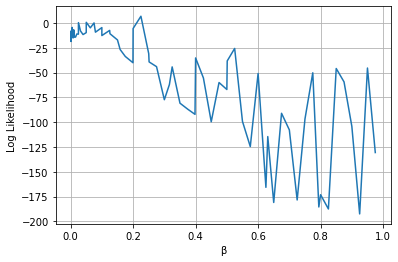

In [ ]:
print("β_MLE =",np.round(beta_MLE,2))
print("β_actual =",beta1)

plt.plot(at,L_n)
plt.grid()
plt.xlabel("β")
plt.ylabel("Log Likelihood")

### In general, this method seems to be unreliable, as it is highly dependent on the data, the sampling process is noisy, the exponential is subject to overflow errors, and the initial guess for beta must be fairly close to the actual value. A more sophisticated optimization procedure seems to be necessary.

# Part 2: Problog Inference 
## Tianyu Zhang 

### **Data Preprocessing:**

(Due to the huge size of G_np, the run time will be pretty long, est ~10-20 mins. We also use sample matrices Ga/Gbs as demonstration. 

In [ ]:
#Graph = G_np
#Graph = Ga
Graph = Gbs
beta = 0.7
it = np.shape(Graph)[0]
state6 = f_Gibbs_Ising(it,beta,Graph)
page_rank, v, v_sort = f_Page_Rank(Graph)

def get_top_3(vetex):
  ''' we find the top 3 pageranked neighbors of a node and its corresponding 
  indices in labels'''
  G_np_list = np.squeeze(np.asarray(Ga[vetex]))
  N_neighbor = np.argwhere(G_np_list == 1.0).flatten().tolist()
  Neighbor_PR = page_rank[N_neighbor]
  top_3 = np.sort(Neighbor_PR)[::-1][:3]
  indices = [page_rank.tolist().index(i) for i in top_3 ]
  return indices


In [ ]:
def get_prob_top3(indices,start_prob):
  from sympy import symbols, solve
  x = symbols('x')
  expr = 1 - start_prob*((x**9 -1)/(x-1))
  sol = solve(expr)
  for i in range(3):
    print("probability of neighbor:" ,i+1 )
    print(start_prob*(sol[1])**i  )

### Tests and Inferences

In [ ]:
#Decide a vertex
vertex = 6;

In [ ]:
# Test1: starting probability is 0.5, get corresponding probability 
print("given label of our vertex:")
print(state6[vertex])
indices = get_top_3(vertex)
start_prob = 0.5
get_prob_top3(indices,start_prob)
print("actual neighbors' label:")
print(state6[indices])
print("predicted label with probability:")

given label of our vertex:
-1
probability of neighbor: 1
0.500000000000000
probability of neighbor: 2
0.250497088961445
probability of neighbor: 3
0.125497583156316
actual neighbors' label:
[-1 -1 -1]
predicted label with probability:


In [ ]:
#Problog Code for inference to predict the probability of top3 neighbors label.
# when start probability is 0.5

0.5::first.
0.5::second.
0.5::third.

0.875::vertex :- first, second, third.
0.75::vertex :- first, second, \+third.
0.625::vertex :- first, \+second, third.
0.5::vertex :- first, \+second, \+third.
0.375::vertex :- \+first, second, third.
0.25::vertex :- \+first, second, \+third.
0.125::vertex :- \+first, \+second, third.
0.125::vertex :- \+first, \+second, \+third.


evidence(vertex,true).
%evidence(vertex,false).
query(first).
query(second).
query(third).

Result:

When vertex labeled 1:

probability of neighbor node being 1: 

first:	0.75862069

second:	0.62068966

third:	0.55172414

when vertex labeled -1:

probability of neighbor node being 1: 

first:	0.28571429

second:	0.4

third: 0.45714286


In [ ]:
# Test2: starting probability is 0.6, get corresponding probability 
print("given label of our vertex:")
print(state6[vertex])
indices = get_top_3(vertex)
start_prob = 0.6
get_prob_top3(indices,start_prob)
print("actual neighbors' label:")
print(state6[indices])
print("predicted label with probability:")

given label of our vertex:
1
probability of neighbor: 1
0.600000000000000
probability of neighbor: 2
0.240094707534191
probability of neighbor: 3
0.0960757809765478
actual neighbors' label:
[ 1  1 -1]
predicted label with probability:


In [ ]:
#problog inference for predicting the probability of top3 neighbors label.
# when start probability is 0.6

0.5::first.
0.5::second.
0.5::third.

0.936::vertex :- first, second, third.
0.84::vertex :- first, second, \+third.
0.696::vertex :- first, \+second, third.
0.6::vertex :- first, \+second, \+third.
0.336::vertex :- \+first, second, third.
0.24::vertex :- \+first, second, \+third.
0.096::vertex :- \+first, \+second, third.
0.066::vertex :- \+first, \+second, \+third.


evidence(vertex,true).
%evidence(vertex,false).
query(first).
query(second).
query(third).

Result: 

When vertex labeled 1:

probability of neighbor node being 1: 

first: 0.80629921

second: 0.61732283

third: 0.54173228


when vertex labeled -1:

probability of neighbor node being 1: 

first: 0.22147971

second: 0.39331742

third: 0.46205251


In [ ]:
# Test3: starting probability is 0.7, get corresponding probability 
print("given label of our vertex:")
print(state6[vertex])
indices = get_top_3(vertex)
start_prob = 0.7
get_prob_top3(indices,start_prob)
print("actual neighbors' label:")
print(state6[indices])
print("predicted label with probability:")

given label of our vertex:
1
probability of neighbor: 1
0.700000000000000
probability of neighbor: 2
0.210009648658939
probability of neighbor: 3
0.0630057893283584
actual neighbors' label:
[-1 -1  1]
predicted label with probability:


In [ ]:
#problog inference for predicting the probability of top3 neighbors label.
# when start probability is 0.7

0.5::first.
0.5::second.
0.5::third.

0.973::vertex :- first, second, third.
0.91::vertex :- first, second, \+third.
0.76::vertex :- first, \+second, third.
0.7::vertex :- first, \+second, \+third.
0.273::vertex :- \+first, second, third.
0.21::vertex :- \+first, second, \+third.
0.063::vertex :- \+first, \+second, third.
0.027::vertex :- \+first, \+second, \+third.


evidence(vertex,true).
%evidence(vertex,false).
query(first).
query(second).
query(third).

Result: 

When vertex labeled 1:

probability of neighbor node being 1: 

first: 0.85367722

second: 0.60418795

third: 0.52834525

when vertex labeled -1:

probability of neighbor node being 1: 

first: 0.16087169

second: 0.40009794

third: 0.47282076

In [ ]:
# Test4: starting probability is 0.8, get corresponding probability 
print("given label of our vertex:")
print(state6[vertex])
indices = get_top_3(vertex)
start_prob = 0.8
get_prob_top3(indices,start_prob)
print("actual neighbors' label:")
print(state6[indices])
print("predicted label with probability")

In [ ]:
#problog inference for predicting the probability of top3 neighbors label.
# when start probability is 0.8

0.5::first.
0.5::second.
0.5::third.

0.992::vertex :- first, second, third.
0.96::vertex :- first, second, \+third.
0.832::vertex :- first, \+second, third.
0.8::vertex :- first, \+second, \+third.
0.192::vertex :- \+first, second, third.
0.16::vertex :- \+first, second, \+third.
0.032::vertex :- \+first, \+second, third.
0.008::vertex :- \+first, \+second, \+third.


evidence(vertex,true).
%evidence(vertex,false).
query(first).
query(second).
query(third).

Result: 

When vertex labeled 1:

probability of neighbor node being 1: 

first: 0.90140845

second: 0.57947686

third: 0.51509054

when vertex labeled -1:

probability of neighbor node being 1: 

first: 0.10337972

second: 0.42147117

third: 0.48508946


In [ ]:
# Actual distribution of labels in node's neighbor
num_1 = state6.tolist().count(1);
num_minus_1 =state6.tolist().count(-1);

first_1 = 0
first_minus_1 =0
second_1 =0
second_minus_1 =0
third_1=0
third_minus_1 =0
first_neg_1 =0
first_neg_minus_1 =0
second_neg_1 =0
second_neg_minus_1 =0
third_neg_1 =0
third_neg_minus_1 =0



 
for i in range(len(state6)):
  vertex = i
  indices = get_top_3(vertex)
  #print(state6[indices])
  if len(state6[indices]) == 3:
    if state6[i] == 1:  
      if state6[indices][0] == 1:
        first_1 +=1
      else:
        first_minus_1 +=1
      if state6[indices][1] == 1:
        second_1 +=1
      else:
        second_minus_1 +=1
      if state6[indices][2] == 1:
        third_1 +=1
      else:
        third_minus_1 +=1
    else:
      if state6[indices][0] == 1:
        first_neg_1 += 1
      else:
        first_neg_minus_1 +=1
      if state6[indices][1] == 1:
        second_neg_1 += 1
      else:
        second_neg_minus_1 +=1
      if state6[indices][2] == 1:
        third_neg_1 += 1
      else:
        third_neg_minus_1 +=1

print("distribution of neighbors when vertex is 1 ")
print("ratio of first neighbor being 1")
print(first_1/num_1)
print("ratio of second neighbor being 1")
print(second_1/num_1)
print("ratio of third neighbor being 1")
print(third_1/num_1)


print("distribution of neighbors when vertex is -1 ")
print("ratio of first neighbor being 1")
print(first_neg_1/num_minus_1)
print("ratio of second neighbor being 1")
print(second_neg_1/num_minus_1)
print("ratio of third neighbor being 1")
print(third_neg_1/num_minus_1)

distribution of neighbors when vertex is 1 
ratio of first neighbor being 1
0.5116279069767442
ratio of second neighbor being 1
0.5581395348837209
ratio of third neighbor being 1
0.5116279069767442
distribution of neighbors when vertex is -1 
ratio of first neighbor being 1
0.2631578947368421
ratio of second neighbor being 1
0.2807017543859649
ratio of third neighbor being 1
0.2807017543859649


Due to the limitation of inference, we may not be able to concisely decide which starting probability should we use. We may need to put more nodes/starting probabilities into consideration. 